# Notebook Function:
    - prepare figures for analysis 

In [2]:
import os, sys
import itertools
import numpy as np
import pandas as pd
import statistics
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
from daylongtranscript import*

loaded


## Preprocessing

In [ ]:
# read in transcripts 
## NOTE: need to create a tab-delimited txt file of the transcripts used to run this section of code (use clean_transcript.py to do this)
#  & for running analyses for select features ; do not need this for the other analyses 
transcript_fpath = ""
A787_files = ["A787_001107_cleaned.txt", "A787_001109_cleaned.txt", "A787_001111_cleaned.txt"]
transcriptA1 = DaylongTranscript(fpath = transcript_fpath+A787_files[0], fname = A787_files[0], isVanDam=False)
transcriptA2 = DaylongTranscript(fpath = transcript_fpath+A787_files[1], fname = A787_files[1], isVanDam=False)
transcriptA3 = DaylongTranscript(fpath = transcript_fpath+A787_files[2], fname = A787_files[2], isVanDam=False)

B895_files = ["B895_010002_cleaned.txt", "B895_010004_cleaned.txt"]
transcriptB1 = DaylongTranscript(fpath = transcript_fpath+B895_files[0], fname = B895_files[0], isVanDam=False)
transcriptB2 = DaylongTranscript(fpath = transcript_fpath+B895_files[1], fname = B895_files[1], isVanDam=False)

fname = "BN32_clean.txt"
transcriptC = DaylongTranscript(fpath = transcript_fpath+fname, fname = fname, isVanDam = True)

TRANSCRIPTS = [transcriptA1, transcriptA2, transcriptA3, transcriptB1, transcriptB2, transcriptC]
transcripts_dict = {"A1": transcriptA1, "A2": transcriptA2, "A3": transcriptA3, "B1": transcriptB1, "B2": transcriptB2, "C": transcriptC}


In [13]:
SIM_TYPE = ["30 seconds", "1 minute", "5 minutes", "10 minutes", "30 minutes", "60 minutes"]
TOTAL_TS = ["30", "40", "50", "60", "70", "80", "90", "100", "110", "120"] # in minutes 
TOTAL_TS_3HR = ["130", '140', '150', '160', '170', '180'] # in minutes
PROP_TTS = [5,10,20,30,40,50,60,70,80,90] 
TRANSCRIPT_LABELS = ["A1", "A2", "A3", "B1", "B2", "C"]

In [5]:
COLOR_PAL_DICT = {'blue':'#0077BB', 'cyan': '#33BBEE', "teal": '#009988', 'orange':'#EE7733', 'red':'#CC3311', 'magenta':'#EE3377'}
COLOR_PAL_LIST = list(COLOR_PAL_DICT.values())
COLOR_PAL_DEF = ['#EE7733', '#0077BB', '#33BBEE', '#EE3377', '#CC3311', '#009988']

### General use functions

In [6]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [12]:
plt.rcParams['font.weight'] = 'bold'
plt.rcParams["axes.labelweight"] = "bold"

# Analyses: Sampling Int Size, Total Sampled Time 

In [20]:
def prop_of_samples(df, cols):
    ''' 
    - given a dataframe & total time sampled, will output proportion of samples greater than 2%, 5%, 10%, and 20% error
    '''
    print("Proportion of samples > x% error")
    for col in cols :
        temp_df = df[col]
        samples_2 = len(temp_df[temp_df>2]) / 600
        samples_5 = len(temp_df[temp_df>5]) / 600
        samples_10 = len(temp_df[temp_df>10]) / 600
        samples_20 = len(temp_df[temp_df>20]) / 600
        print(f'--{col} group\n> 2%: {samples_2:<25}\t> 5%: {samples_5:<25}\t > 10%: {samples_10:<25}\t>20%: {samples_20}')
        print()
    return

def grp_means_stds(group):
    return group.mean(), group.std()

def make_errorplots(df, sampled_feature = "[sampled feature]", subtitle = 'sampling interval size = 30 seconds', 
                    x_label = "total time sampled (minutes)", save = False):
    ''' 
    - makes two panel percent error plots (panel 1: overall error; panel 2: individual transcript error)
    '''
    df_stats = df.describe()
    overall_mean = df.mean()
    overall_std = df.std()
    range = np.array([overall_mean - df_stats.loc['min'],  df_stats.loc['max'] - overall_mean])
    iqr = [overall_mean - df_stats.loc['25%'], df_stats.loc['75%'] - overall_mean]
    middle_90 = [overall_mean - df.quantile(0.05), df.quantile(0.95) - overall_mean]

    fig,axes = plt.subplots(1,2, figsize = (12,5), dpi = 500, sharey = False)
    color_list = [COLOR_PAL_DICT["blue"], COLOR_PAL_DICT["orange"], COLOR_PAL_DICT['red']]
    axes[0].errorbar(x = overall_mean.index,  y = overall_mean, marker="o", markerfacecolor=color_list[0], 
                    linestyle="--", color = color_list[0], label = "mean")
    axes[0].errorbar(x = overall_mean.index,  y = overall_mean, yerr = range, label="range", 
                    fmt = "none", ecolor = color_list[0],  capsize = 3)
    axes[0].errorbar(x = overall_mean.index,  y = overall_mean, yerr = middle_90, label="90% of values", fmt = 'none',
                    ecolor = color_list[1], elinewidth = 5)
    axes[0].errorbar(x = overall_mean.index,  y = overall_mean, yerr = iqr, label="50% of values", fmt = 'none',  
                    ecolor = color_list[2], elinewidth=10)
    axes[0].legend()
    axes[0].set_title("Across all Transcripts", fontweight = "bold")
    #axes[0].set_yticks([5,10,15,20,25,30,35,40])
    axes[0].set_ylabel("mean percent error", fontweight = "bold")
    axes[0].set_xlabel(f"{x_label}", fontweight = "bold")
    legend_properties = {'weight':'bold', 'size': 11}
    axes[0].legend(prop=legend_properties) 
    #ax[0].set_xticks(ax[0].get_xticklabels(), rotation = 30)

    color_list = list(COLOR_PAL_LIST)
    grouped = df.groupby("Transcript")
    for i, transcript_key in enumerate(TRANSCRIPT_LABELS):
        if transcript_key not in df["Transcript"].values: continue
        group =grouped.get_group(transcript_key)
        grp_means, grp_stds = grp_means_stds(group)
        axes[1].errorbar(x=grp_means.index, y=grp_means, label=transcript_key, marker = "o", markerfacecolor = color_list[i], color = color_list[i])
        legend_properties = {'weight':'bold', 'size': 11}
        axes[1].legend(prop=legend_properties) 
        axes[1].set_title("Individual Transcripts", fontweight = "bold")
        axes[1].set_xlabel(f"{x_label}", fontweight = "bold")

    for ax in axes:
        ax.set_xticklabels(ax.get_xticklabels(),fontweight = 'bold', rotation = 15)
        ax.set_yticklabels(ax.get_yticklabels(),fontweight = 'bold')

    plt.suptitle(f"Mean Percent Error of Estimates {sampled_feature}\n{subtitle}", fontweight = "bold")
    plt.tight_layout()
    plt.show()

def make_eventplot(event_occurrences, event_label = "SET LABEL"):
    fig, ax = plt.subplots(figsize = (16,6), dpi = 500,facecolor ='w')
    lineoffsets = [5.25, 5.25, 4.0, 4.0, 2.5, 2.5, 1.25, 1.25, 0.0, 0.0, -1.2, -1.2]
    y_ticks = [5.25, 4.0, 2.5, 1.25, 0.0, -1.2]
    speech_c = '#77AADD'
    event_c = '#EE3377'
    colors = [speech_c, event_c, speech_c, event_c, speech_c, event_c, speech_c, event_c, speech_c, event_c, speech_c, event_c]
    ax.eventplot(positions = event_occurrences, lineoffsets=lineoffsets, linelengths=0.8, 
                 colors = colors, alpha = 0.8)
    ax.set_yticks(ticks = [5.25, 4.0, 2.5, 1.25, 0.0, -1.2], labels = TRANSCRIPT_LABELS,
                fontweight = "bold", fontsize = 16)
    plt.setp(ax.get_xticklabels(), fontsize=14, fontweight='bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel("time across recording (minutes) ", fontweight = "bold", fontsize = 16)
    plt.title(f"Occurrences of {event_label} across recordings",fontweight = "bold", fontsize = 16)
    plt.show()


## Sampling Interval Size

In [11]:
# read in csv
perr_samplingintsize = pd.read_csv("Results/CSVS/PercentError_samplingintsize.csv", 
                                 skiprows = 0, header = 1)
perr_samplingintsize.describe()

,30 seconds,1 minute,5 minutes,10 minutes,30 minutes,60 minutes
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,4.354495,5.848208,9.284598,12.238165,18.716397,22.871803
std,3.492593,4.655423,7.847098,10.749096,16.181828,19.603213
min,0.006000,0.017000,0.006000,0.043000,0.022000,0.004000
25%,1.636750,2.374750,3.690750,4.340250,6.861500,9.913750
50%,3.653500,4.906500,7.184500,9.558500,14.117000,17.094500
75%,6.324250,8.316250,12.446250,16.764750,25.241000,30.583500
max,19.264000,29.714000,42.180000,71.688000,85.975000,125.266000


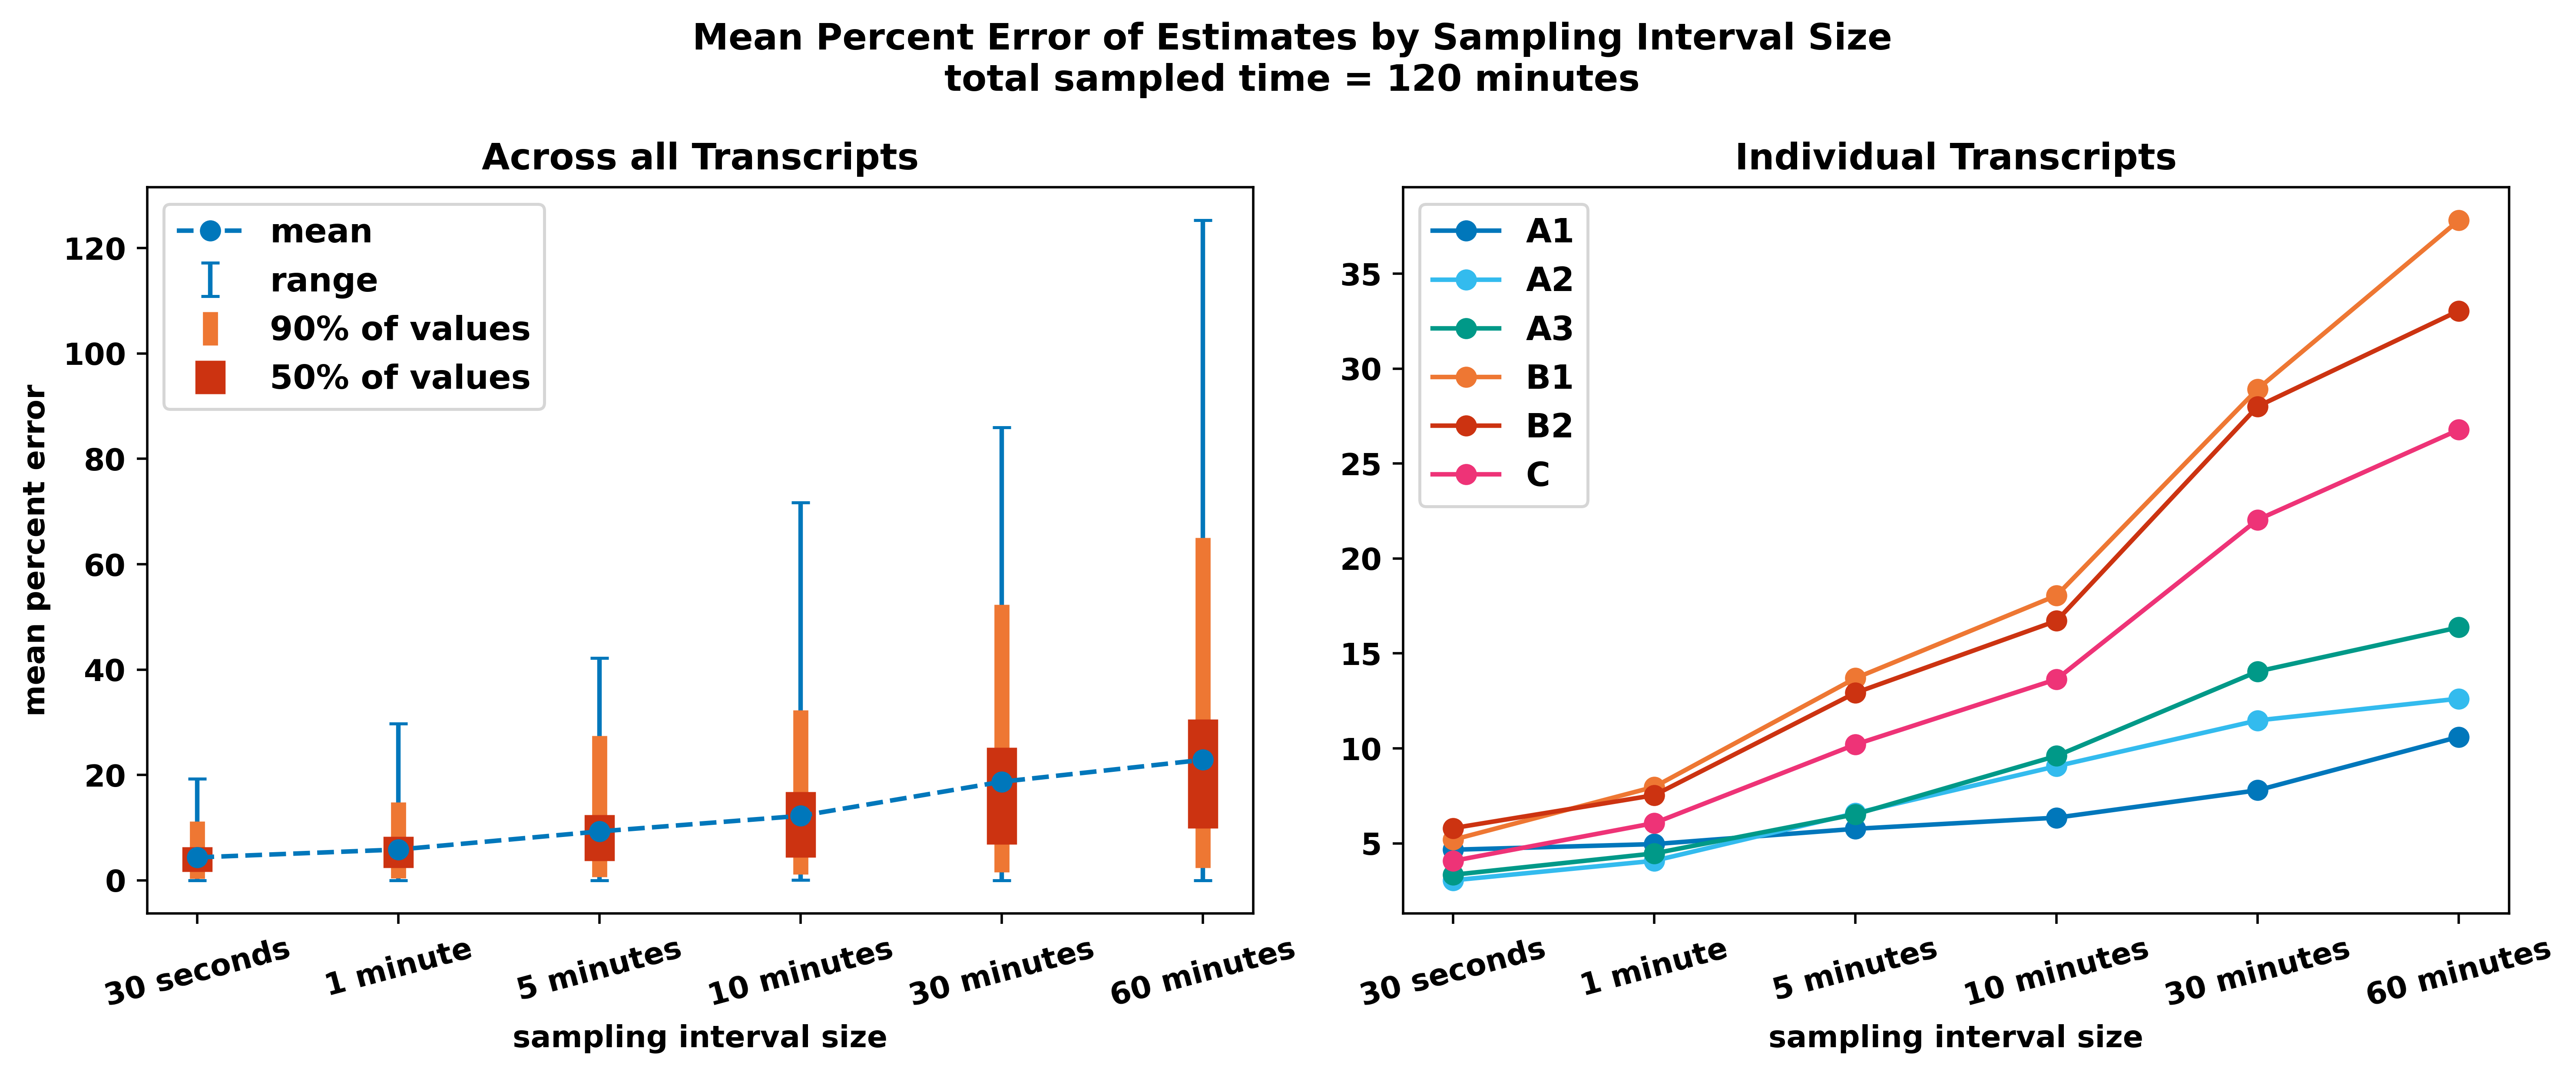

In [12]:
make_errorplots(df = perr_samplingintsize, sampled_feature = "by Sampling Interval Size", subtitle = "total sampled time = 120 minutes",
                x_label="sampling interval size")

In [13]:
prop_of_samples(perr_samplingintsize, cols = SIM_TYPE)

Proportion of samples > x% error
--30 seconds group
> 2%: 0.71                     	> 5%: 0.3516666666666667       	 > 10%: 0.07333333333333333      	>20%: 0.0

--1 minute group
> 2%: 0.7883333333333333       	> 5%: 0.49                     	 > 10%: 0.16166666666666665      	>20%: 0.011666666666666667

--5 minutes group
> 2%: 0.8533333333333334       	> 5%: 0.655                    	 > 10%: 0.3516666666666667       	>20%: 0.11

--10 minutes group
> 2%: 0.8866666666666667       	> 5%: 0.725                    	 > 10%: 0.47833333333333333      	>20%: 0.19166666666666668

--30 minutes group
> 2%: 0.935                    	> 5%: 0.8166666666666667       	 > 10%: 0.6466666666666666       	>20%: 0.335

--60 minutes group
> 2%: 0.9616666666666667       	> 5%: 0.8983333333333333       	 > 10%: 0.7466666666666667       	>20%: 0.41833333333333333



## Total Time Sampled (minutes)

In [14]:
# read in csv
columns_dict = {'30': 30.0, '40': 40.0, '50': 50.0, '60': 60.0, '70':70.0, '80':80.0, 
              '90':90.0, '100':100.0, '110': 110.0, '120': 120.0, '130':130.0, '140':140.0, 
              '150':150.0, '160':160.0, '170':170.0, '180':180.0, 'Transcript':'Transcript'}
perr_tts_asminutes = pd.read_csv("Results/CSVS/PercentError_TTS_180min_30sec.csv", 
                                 skiprows = 0, header = 1)#.rename(columns=columns_dict)

In [15]:
perr_tts_asminutes.describe()

,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,8.655332,7.399945,6.598867,5.941320,5.449600,5.567018,5.153410,4.939130,4.694667,4.354495,4.293918,4.177730,3.975810,3.639775,3.709067,3.718550
std,7.314723,6.037646,5.243022,5.025619,4.155191,4.392495,3.902589,3.818919,3.915816,3.492593,3.557767,3.291441,3.156808,2.988031,2.961991,2.985896
min,0.022000,0.005000,0.022000,0.002000,0.028000,0.014000,0.001000,0.030000,0.007000,0.006000,0.015000,0.003000,0.013000,0.012000,0.019000,0.019000
25%,3.313000,2.711000,2.660000,2.202000,2.143000,2.211750,2.021000,1.937500,1.807250,1.636750,1.564000,1.701000,1.518500,1.431250,1.446500,1.328000
50%,6.628500,5.880500,5.303500,4.839000,4.645500,4.444000,4.378500,4.132500,3.437000,3.653500,3.470500,3.530500,3.214500,2.966500,3.099000,3.124500
75%,11.955000,10.154500,9.172500,8.261500,7.719000,8.063250,7.324500,7.158750,6.967750,6.324250,5.921250,5.847000,5.607500,5.018000,5.178250,5.417250
max,41.734000,32.800000,28.407000,29.411000,21.895000,22.743000,23.230000,20.587000,22.891000,19.264000,18.380000,19.987000,16.615000,20.346000,18.560000,17.976000


In [16]:
prop_of_samples(df = perr_tts_asminutes, cols = TOTAL_TS + TOTAL_TS_3HR)

Proportion of samples > x% error
--30 group
> 2%: 0.8666666666666667       	> 5%: 0.6166666666666667       	 > 10%: 0.31666666666666665      	>20%: 0.07666666666666666

--40 group
> 2%: 0.815                    	> 5%: 0.5616666666666666       	 > 10%: 0.25833333333333336      	>20%: 0.04666666666666667

--50 group
> 2%: 0.8                      	> 5%: 0.5233333333333333       	 > 10%: 0.22                     	>20%: 0.016666666666666666

--60 group
> 2%: 0.7733333333333333       	> 5%: 0.48833333333333334      	 > 10%: 0.17166666666666666      	>20%: 0.023333333333333334

--70 group
> 2%: 0.765                    	> 5%: 0.46166666666666667      	 > 10%: 0.15                     	>20%: 0.0016666666666666668

--80 group
> 2%: 0.77                     	> 5%: 0.45666666666666667      	 > 10%: 0.15666666666666668      	>20%: 0.005

--90 group
> 2%: 0.7566666666666667       	> 5%: 0.45166666666666666      	 > 10%: 0.12333333333333334      	>20%: 0.0016666666666666668

--100 group
> 2%: 0.738

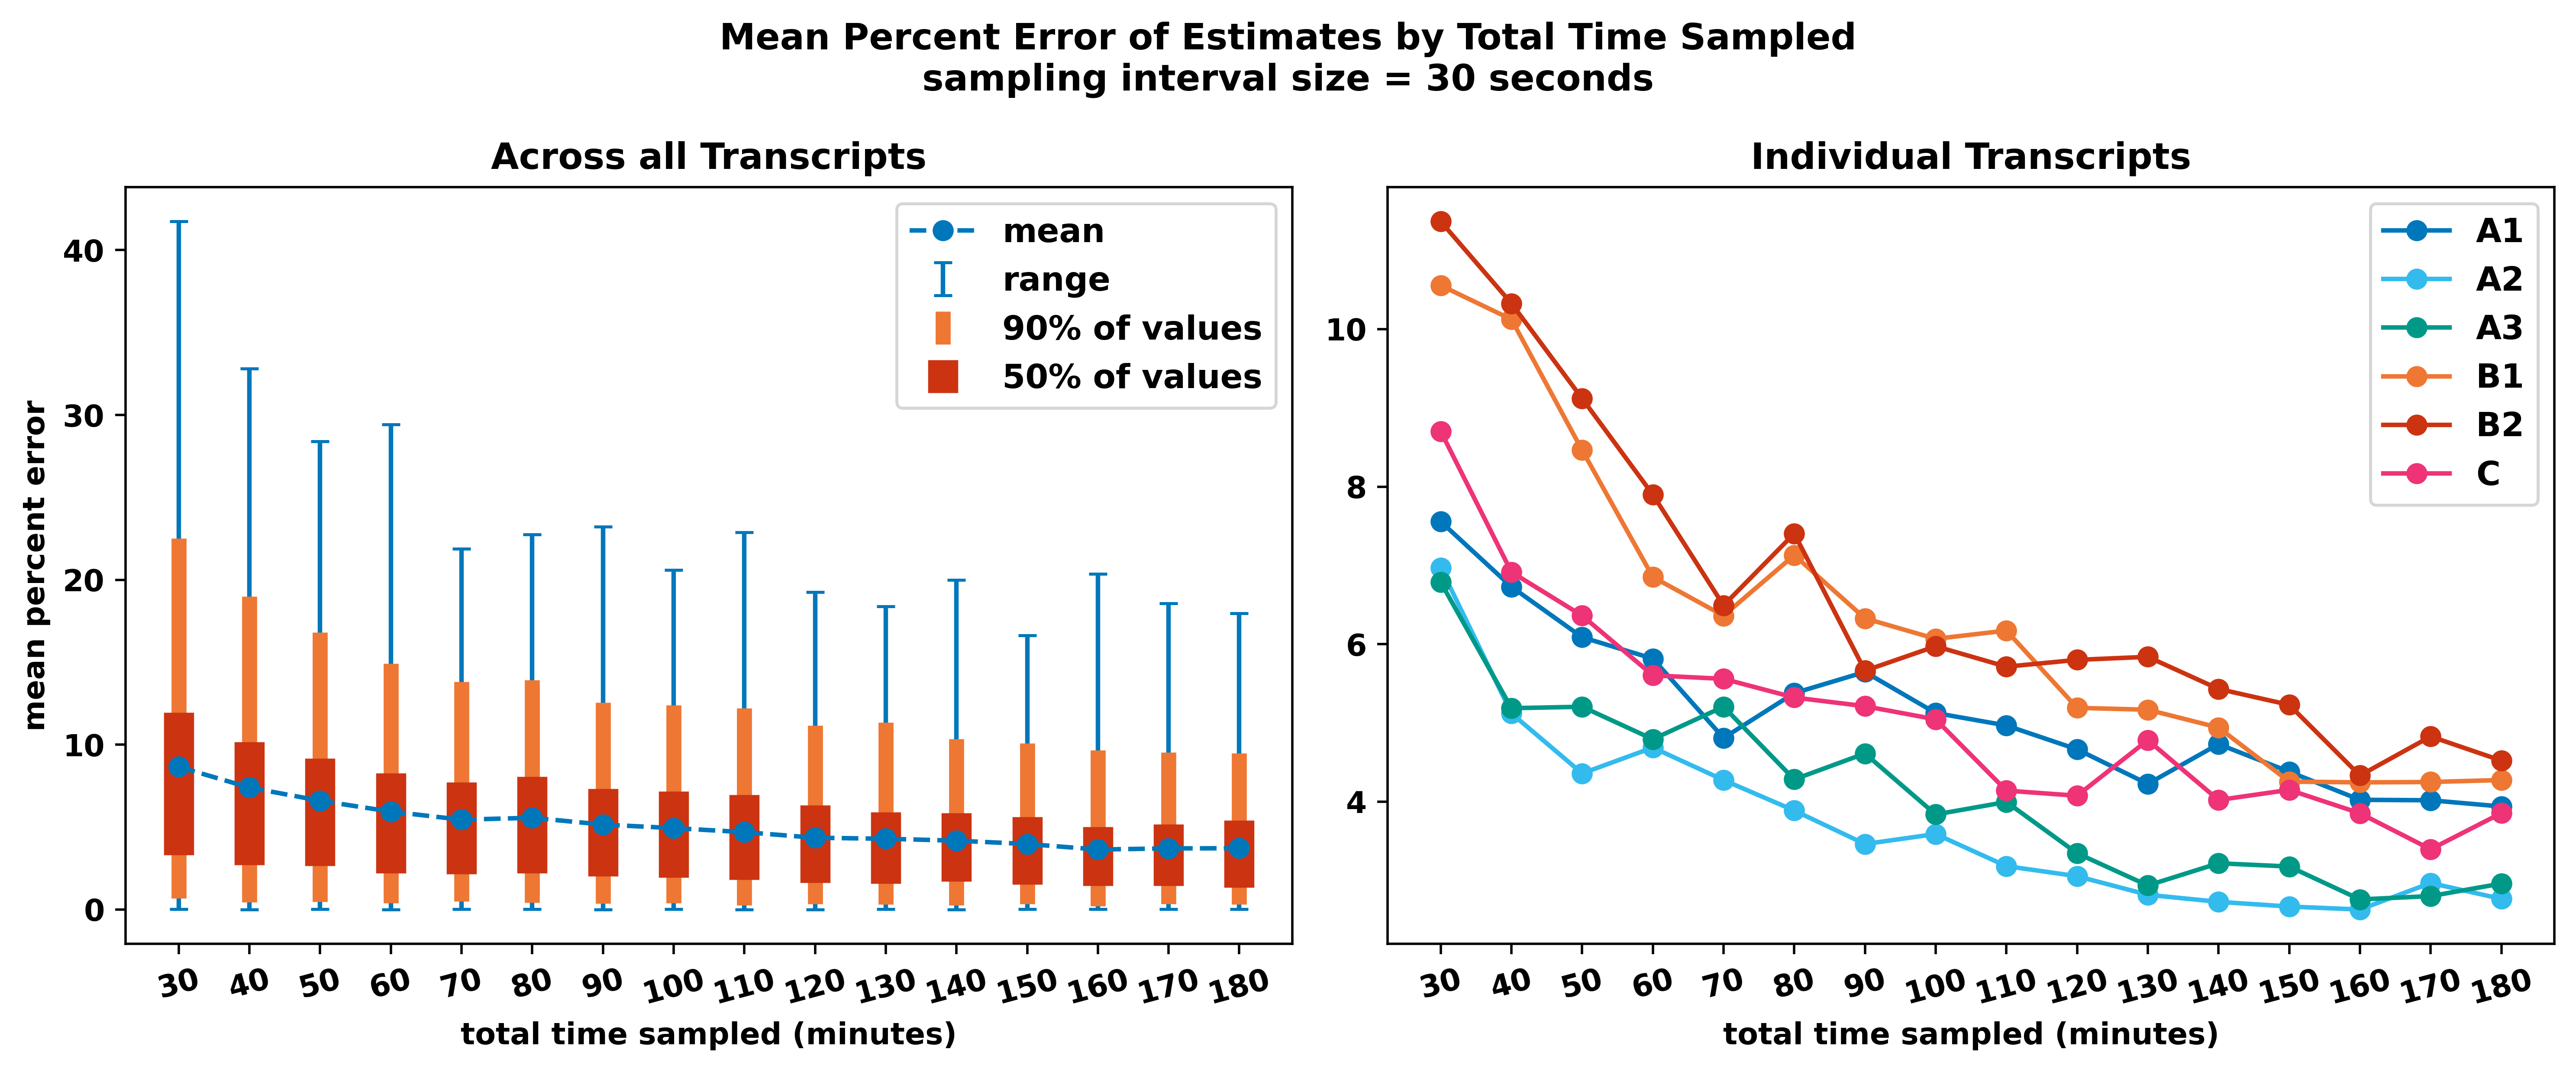

In [17]:
make_errorplots(df = perr_tts_asminutes, sampled_feature = "by Total Time Sampled")

## Total Sampling Time (proportion)

In [18]:
cols = {"0.05": 5, "0.1": 10, "0.2": 20, "0.3":30, "0.4":40, "0.5":50, "0.6":60, "0.7":70, "0.8":80, "0.9":90}
perr_tts_asprop = pd.read_csv(filepath_or_buffer="Results/CSVS/PercentError_propTTS.csv",
                              skiprows = 0, header = 1).rename(columns = cols )
perr_tts_asprop.describe()

,5,10,20,30,40,50,60,70,80,90
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,7.700173,5.430495,4.147037,3.380367,2.841397,2.746407,2.392088,2.456992,2.270508,2.099005
std,6.450063,4.585816,3.378220,2.734263,2.317991,2.310569,1.847782,1.830575,1.800089,1.753310
min,0.008000,0.021000,0.012000,0.012000,0.004000,0.005000,0.001000,0.003000,0.003000,0.001000
25%,2.992000,2.092250,1.710750,1.254750,1.103000,0.972500,0.897000,1.045750,0.921250,0.717500
50%,6.181500,4.214000,3.461000,2.725000,2.294500,2.158000,1.968500,2.173500,1.867000,1.661500
75%,10.478750,7.538500,5.684750,4.859250,3.897500,3.970000,3.439000,3.306750,3.217250,2.977000
max,48.442000,25.025000,22.653000,16.427000,14.195000,13.626000,9.973000,10.812000,10.715000,9.086000


In [20]:
prop_of_samples(df =perr_tts_asprop, cols = PROP_TTS )

Proportion of samples > x% error
--5 group
> 2%: 0.8283333333333334       	> 5%: 0.5883333333333334       	 > 10%: 0.27666666666666667      	>20%: 0.06166666666666667

--10 group
> 2%: 0.7583333333333333       	> 5%: 0.43833333333333335      	 > 10%: 0.15                     	>20%: 0.018333333333333333

--20 group
> 2%: 0.6866666666666666       	> 5%: 0.31666666666666665      	 > 10%: 0.058333333333333334     	>20%: 0.0033333333333333335

--30 group
> 2%: 0.6266666666666667       	> 5%: 0.23333333333333334      	 > 10%: 0.025                    	>20%: 0.0

--40 group
> 2%: 0.545                    	> 5%: 0.15666666666666668      	 > 10%: 0.01                     	>20%: 0.0

--50 group
> 2%: 0.5233333333333333       	> 5%: 0.155                    	 > 10%: 0.011666666666666667     	>20%: 0.0

--60 group
> 2%: 0.49166666666666664      	> 5%: 0.09666666666666666      	 > 10%: 0.0                      	>20%: 0.0

--70 group
> 2%: 0.54                     	> 5%: 0.09333333333333334      	 >

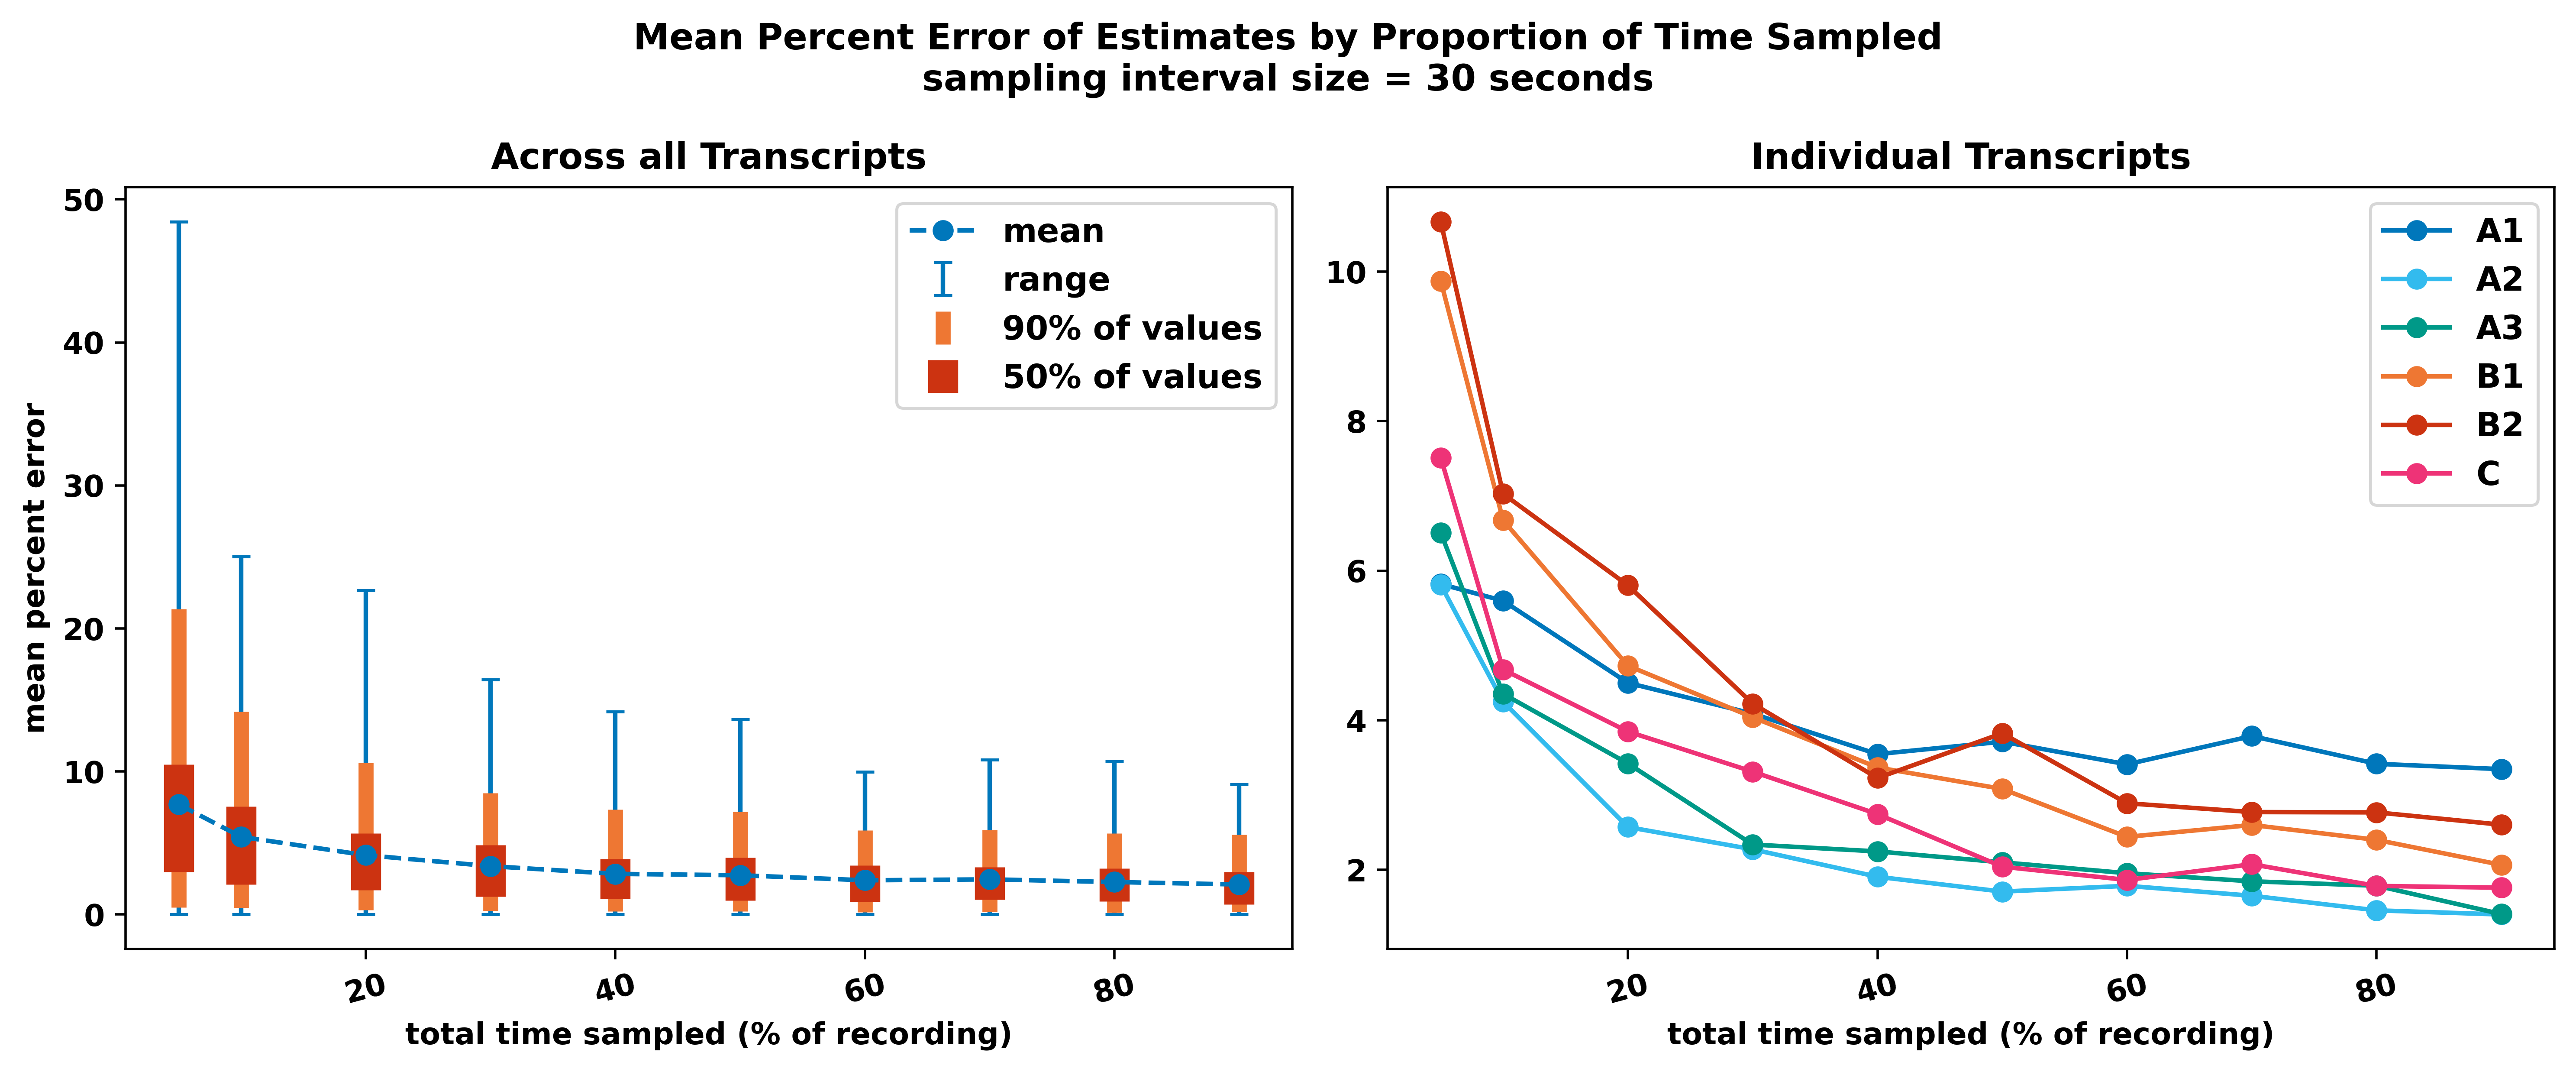

In [21]:
make_errorplots(df = perr_tts_asprop, sampled_feature = "by Proportion of Time Sampled", 
                x_label = "total time sampled (% of recording)")

# Analysis: Select Features

In [21]:
def get_feature_density(transcript, feature_dict):
    raw_amount = transcript.feature_count(feature_dict = feature_dict)
    denom_feature = 0
    # calculate density by either using overall word counts or utterance counts, depending on feature type 
    if list(feature_dict.keys())[0] == "utterance_annotation":
        denom_feature = len(transcript.utterances)
    else: denom_feature = transcript.get_total_word_count()
    density = raw_amount / denom_feature 
    return raw_amount, density 

def get_feature_densities(feature_dicts, transcripts = TRANSCRIPTS, transcript_labels = TRANSCRIPT_LABELS):
    '''
    - wrapper function for get_feature_density'''
    C_xds_codes = {"T": "id", "A": "od", "C": None, 'O': None, 'U': None}
    densities = []
    for feature_dict in feature_dicts:
        feature_type = list(feature_dict.keys())[0]
        feature = list(feature_dict.values())[0]       
        print(f"Feature densities for: {feature_type}, {feature}")
        for i, transcript in enumerate(transcripts):
            if transcript_labels[i] == "C": 
                if feature_type == "utterance_annotation": continue 
                elif feature_type == "xds": 
                    feature = C_xds_codes[feature]
                    feature_dict = {"xds": feature}
            raw_amount, density = get_feature_density(transcript, feature_dict)
            print(f"\t{transcript_labels[i]:<5}: {raw_amount:<5} \t {density * 100}")
            densities.append(density * 100)
    #print(f"\n\tMean: {statistics.mean(densities):<5} \tStdev: {statistics.stdev(densities)}")
    return(densities)

In [22]:
# read in csvs
columns_dict = {"0.05": 5, "0.1": 10, "0.2": 20, "0.3":30, "0.4":40, "0.5":50, "0.6":60, "0.7":70, "0.8":80, "0.9":90, 'Transcript':'Transcript'}
perr_selectword_prop = pd.read_csv("Results/CSVS/SelectFeatures/Prop_TTS/percenterror_selectword.csv", 
                              skiprows = 0, header = 1).rename(columns=columns_dict)
perr_cds_prop = pd.read_csv("Results/CSVS/SelectFeatures/Prop_TTS/percenterror_cds.csv", 
                              skiprows = 0, header = 1).rename(columns=columns_dict)
perr_questions_prop = pd.read_csv("Results/CSVS/SelectFeatures/Prop_TTS/percenterror_questions.csv", 
                              skiprows = 0, header = 1).rename(columns=columns_dict)
perr_imit_prop = pd.read_csv("Results/CSVS/SelectFeatures/Prop_TTS/percenterror_imit.csv", 
                              skiprows = 0, header = 1).rename(columns=columns_dict)
perr_exclamation_prop = pd.read_csv("Results/CSVS/SelectFeatures/Prop_TTS/percenterror_exclamation.csv", 
                               header = 0).rename(columns=columns_dict)
perr_sp_CHI_prop = pd.read_csv("Results/CSVS/SelectFeatures/Prop_TTS/percenterror_sp_CHI.csv", 
                               header = 0).rename(columns=columns_dict)
perr_sp_FA1_prop = pd.read_csv("Results/CSVS/SelectFeatures/Prop_TTS/percenterror_sp_FA1.csv", 
                               header = 0).rename(columns=columns_dict)
perr_sp_FC1_prop = pd.read_csv("Results/CSVS/SelectFeatures/Prop_TTS/percenterror_sp_FC1.csv", 
                               header = 0).rename(columns=columns_dict)
perr_uttannot_prop = pd.read_csv("Results/CSVS/SelectFeatures/Prop_TTS/percenterror_uttannotation.csv", 
                               header = 0).rename(columns=columns_dict)
perr_xds_A_prop = pd.read_csv("Results/CSVS/SelectFeatures/Prop_TTS/percenterror_xds_A.csv", 
                               header = 0).rename(columns=columns_dict)
perr_xds_C_prop = pd.read_csv("Results/CSVS/SelectFeatures/Prop_TTS/percenterror_xds_C.csv", 
                               header = 0).rename(columns=columns_dict)

### Organizing by Density 

In [23]:
# get densities 
print("RARE DENSITY")
rare_density_dicts = [ {"select_word": "eat"}, {"utterance_annotation": "imit"}]
fds = get_feature_densities(rare_density_dicts)
print(f"\n\tMean: {statistics.mean(fds):<5} \tStdev: {statistics.stdev(fds)}")

print("\nLOW DENSITY")
fds = get_feature_densities([{'utterance_annotation': '!'}], transcripts = [transcriptA1,transcriptA2,transcriptA3,transcriptB1], transcript_labels=['A1', 'A2', 'A3', 'B1'])
fds = fds + get_feature_densities([{"speaker":"CHI"}], transcripts = TRANSCRIPTS[0:5], transcript_labels=['A1', 'A2', 'A3', 'B1', 'B2'])
fds = fds + (get_feature_densities([{'xds':'C'}], transcripts = [transcriptB2], transcript_labels=["B2"]))
print(f"\n\tMean: {statistics.mean(fds):<5} \tStdev: {statistics.stdev(fds)}")

print("\nMED DENSITY")
fds = get_feature_densities([{'utterance_annotation':'?'}], transcripts = TRANSCRIPTS[0:5],transcript_labels=['A1', 'A2', 'A3', 'B1', 'B2'])
fds = fds + get_feature_densities([{'speaker':'FC1'}], transcripts=[transcriptA1,transcriptC], transcript_labels=['A1','C'])
fds = fds = get_feature_densities([{'xds':'T'}], transcripts = [transcriptA3, transcriptB1,transcriptB2], transcript_labels=['A3', 'B1', 'B2'])
print(f"\n\tMean: {statistics.mean(fds):<5} \tStdev: {statistics.stdev(fds)}")


print(('\nHIGH DENSITY'))
fds = get_feature_densities([{'xds':'T'}], transcripts = [transcriptA1, transcriptA2, transcriptC], transcript_labels=['A1','A2','C'])
fds = fds+get_feature_densities([{'utterance_annotation':"<"}], transcripts = [transcriptB1, transcriptB2], transcript_labels=['B1', "B2"])
fds = fds+get_feature_densities([{"xds":"A"}], transcripts=TRANSCRIPTS[0:3], transcript_labels=TRANSCRIPT_LABELS[0:3])
fds = fds+get_feature_densities([{"speaker":"FA1"}], transcripts=[transcriptB1, transcriptB2], transcript_labels=['B1','B2'])
print(f"\n\tMean: {statistics.mean(fds):<5} \tStdev: {statistics.stdev(fds)}")

print('\nVERY HIGH DENSITY')
fds = get_feature_densities([{'xds':'C'}], transcripts = TRANSCRIPTS[0:3], transcript_labels=TRANSCRIPT_LABELS[0:3])
fds = fds+get_feature_densities([{'xds':"A"}], transcripts =[transcriptB1, transcriptB2,transcriptC], transcript_labels=["B1", "B2", "C"] )
fds = fds+get_feature_densities([{'speaker':"FA1"}], transcripts = TRANSCRIPTS[0:3]+TRANSCRIPTS[-1:], transcript_labels=["A1", "A2", "A3", "C"])
print(f"\n\tMean: {statistics.mean(fds):<5} \tStdev: {statistics.stdev(fds)}")


RARE DENSITY
Feature densities for: select_word, eat
	A1   : 47    	 0.26994428809373383
	A2   : 74    	 0.26312982256516015
	A3   : 81    	 0.21022034206223558
	B1   : 40    	 0.08476012883539584
	B2   : 34    	 0.11341650543732071
	C    : 39    	 0.13759040395131417
Feature densities for: utterance_annotation, imit
	A1   : 61    	 1.1207054932941392
	A2   : 110   	 1.2458942122550685
	A3   : 130   	 1.0553661308654003
	B1   : 240   	 1.3699412066898795
	B2   : 98    	 1.1435239206534422

	Mean: 0.6376811322457354 	Stdev: 0.5346667891385356

LOW DENSITY
Feature densities for: utterance_annotation, !
	A1   : 535   	 9.829138342825647
	A2   : 596   	 6.750481368218371
	A3   : 1071  	 8.694593278129567
	B1   : 1467  	 8.37376562589189
Feature densities for: speaker, CHI
	A1   : 1308  	 7.512492102693699
	A2   : 2587  	 9.198876364541478
	A3   : 3126  	 8.112948015883315
	B1   : 3874  	 8.209018477708085
	B2   : 1874  	 6.251250917339382
Feature densities for: xds, C
	B2   : 2439  	 8.135

In [24]:
# organize by densities
rare_density = pd.concat([ perr_selectword_prop, perr_imit_prop ], ignore_index = True)
low_density = pd.concat([ perr_exclamation_prop, perr_sp_CHI_prop, perr_xds_C_prop[perr_xds_C_prop["Transcript"].isin(["B2"])] ],
                         ignore_index=True)
med_density = pd.concat([ perr_questions_prop, perr_sp_FC1_prop, perr_cds_prop[perr_cds_prop["Transcript"].isin(["A3", "B1", "B2"])] ], 
                        ignore_index=True)
high_density = pd.concat([ perr_cds_prop[perr_cds_prop["Transcript"].isin(["A1", "A2", "C"])], perr_uttannot_prop,
                          perr_xds_A_prop[perr_xds_A_prop["Transcript"].isin(["A1", "A2", "A3"])], 
                          perr_sp_FA1_prop[perr_sp_FA1_prop["Transcript"].isin(["B1","B2"])] ],  
                         ignore_index=True)

very_high_density = pd.concat([ perr_xds_C_prop[perr_xds_C_prop["Transcript"].isin(["A1", "A2", "A3"])], 
                               perr_xds_A_prop[perr_xds_A_prop["Transcript"].isin(["B1", "B2", "C"])],
                              perr_sp_FA1_prop[perr_sp_FA1_prop["Transcript"].isin(["A1", "A2", "A3", "C"])] ], 
                              ignore_index=True)

#### Estimate error comparisons

In [25]:
error_diff = list(rare_density.mean() / perr_tts_asprop.mean())
print(f'RARE\n{error_diff}\n\t{statistics.mean(error_diff)}, {statistics.stdev(error_diff)}')

error_diff = list(low_density.mean() / perr_tts_asprop.mean())
print(f'LOW\n{error_diff}\n\t{statistics.mean(error_diff)}, {statistics.stdev(error_diff)}')

error_diff = list(med_density.mean() / perr_tts_asprop.mean())
print(f'MED\n{error_diff}\n\t{statistics.mean(error_diff)}, {statistics.stdev(error_diff)}')

error_diff = list(high_density.mean() / perr_tts_asprop.mean())
print(f'HIGH\n{error_diff}\n\t{statistics.mean(error_diff)}, {statistics.stdev(error_diff)}')

error_diff = list(very_high_density.mean() / perr_tts_asprop.mean())
print(f'VERY HIGH\n{error_diff}\n\t{statistics.mean(error_diff)}, {statistics.stdev(error_diff)}')

RARE
[6.340974969001112, 6.158524306632349, 6.164045944161233, 6.1518159676061686, 6.061398102448338, 5.837271665830678, 5.912100007961862, 5.6112996029574305, 5.579464216897101, 5.533269334756249]
	5.935016411825252, 0.2853607622154902
LOW
[1.8835211068841744, 1.9585420850217123, 2.020730384989767, 2.1401633945035514, 2.3290704454030253, 2.2427334140853117, 2.4116793345842145, 2.3323542679224976, 2.403255658608022, 2.6214525453726876]
	2.2343502637374963, 0.2314508949045169
MED
[1.9682917960288342, 1.8962958257028106, 1.86929936315972, 1.9113607005157227, 2.1889551969160697, 1.9482868523962225, 2.166740219320218, 2.093677023731596, 2.1909454931164523, 2.2217231497781107]
	2.0455575620665756, 0.14004839295147425
HIGH
[1.843322401400487, 1.8117009591206719, 1.6255638765351332, 1.8034543589945866, 1.8044432374219739, 1.6808996482676755, 1.750200835671483, 1.5836191277273362, 1.7290286683231721, 1.7477085571496986]
	1.7379941670612218, 0.08516846260261884
VERY HIGH
[1.2549014913950003, 1.

In [141]:
density_dfs= [rare_density, low_density,med_density,high_density,very_high_density,perr_tts_asprop]
density_labels = ["rare","low density","med density","high density", "very high density","all speech"]
for i, df in enumerate(density_dfs):
    print(density_labels[i])
    print(list(df.mean()))
    print()

rare
[48.82660636363653, 33.44383545454548, 25.562524545454583, 20.795393636363652, 17.22283636363635, 16.03152181818181, 14.14226545454547, 13.786916363636381, 12.668220000000005, 11.614360000000039]

low density
[14.503439000000004, 10.635852999999997, 8.380043000000011, 7.234536999999993, 6.617812999999999, 6.159457999999994, 5.768949999999993, 5.730575000000011, 5.456612000000002, 5.502441999999997]

med density
[15.156188000000002, 10.297824999999998, 7.752053000000006, 6.461100000000003, 6.219689999999992, 5.350788000000001, 5.183033999999999, 5.144146999999999, 4.974560000000013, 4.663408000000002]

high density
[14.193901999999992, 9.838433000000025, 6.741273000000002, 6.096337000000005, 5.127139000000001, 4.616433999999999, 4.186635000000003, 3.890939000000001, 3.9257739999999974, 3.6684490000000025]

very high density
[9.662959000000011, 7.534216, 5.084473000000005, 4.346831000000008, 3.7700970000000007, 3.5206210000000056, 3.1828690000000024, 3.0420040000000026, 2.8373589999

## Combined Error Plot

In [26]:
colors_list = [COLOR_PAL_DICT['blue'],COLOR_PAL_DICT['magenta'],COLOR_PAL_DICT['cyan'],COLOR_PAL_DICT['orange'], "black"]
def make_combined_errorplot(dfs, labels, colors, tts_type = "minutes", use_stdevs = False, plot_error_diff = False):
    if colors is None: colors = COLOR_PAL_LIST
    fig,ax = plt.subplots(figsize = (12,5), dpi = 500)
    xvals = dfs[-1].mean().index
    for i, df in enumerate(dfs):
        if use_stdevs is True: yvals = df.std()
        elif plot_error_diff is True: 
            if i == len(dfs)-1: break
            else: yvals =  df.mean() / dfs[-1].mean()
        else: yvals = df.mean()       
        l = labels[i]
        c = colors[i]
        ax.errorbar(x = xvals, y = yvals.values, marker = "o", color = c, label = l)
    legend_properties = {'weight':'bold', 'size': 11}
    ax.legend(prop=legend_properties) 
    plt.xticks(list(list(xvals)))
    ax.set_xlabel(f"total time sampled ({tts_type})", fontweight = "bold")
    ax.set_xticklabels(ax.get_xticklabels(),fontweight = 'bold')
    ax.set_yticklabels(ax.get_yticklabels(),fontweight = 'bold')
    if use_stdevs is True: 
        ax.set_ylabel("standard deviation of estimate error", fontweight = "bold")
        plt.title("Standard Deviation of Estimate Errors for Select Features", fontweight = "bold")
    elif plot_error_diff is True:
        ax.set_ylabel("degree of error", fontweight = "bold")
        plt.title("Degree of Error for Select Features", fontweight = "bold")
    else: 
        ax.set_ylabel("mean percent estimate error", fontweight = "bold")
        plt.title("Mean Percent Error of Estimates for Select Features", fontweight = "bold")
    plt.show()

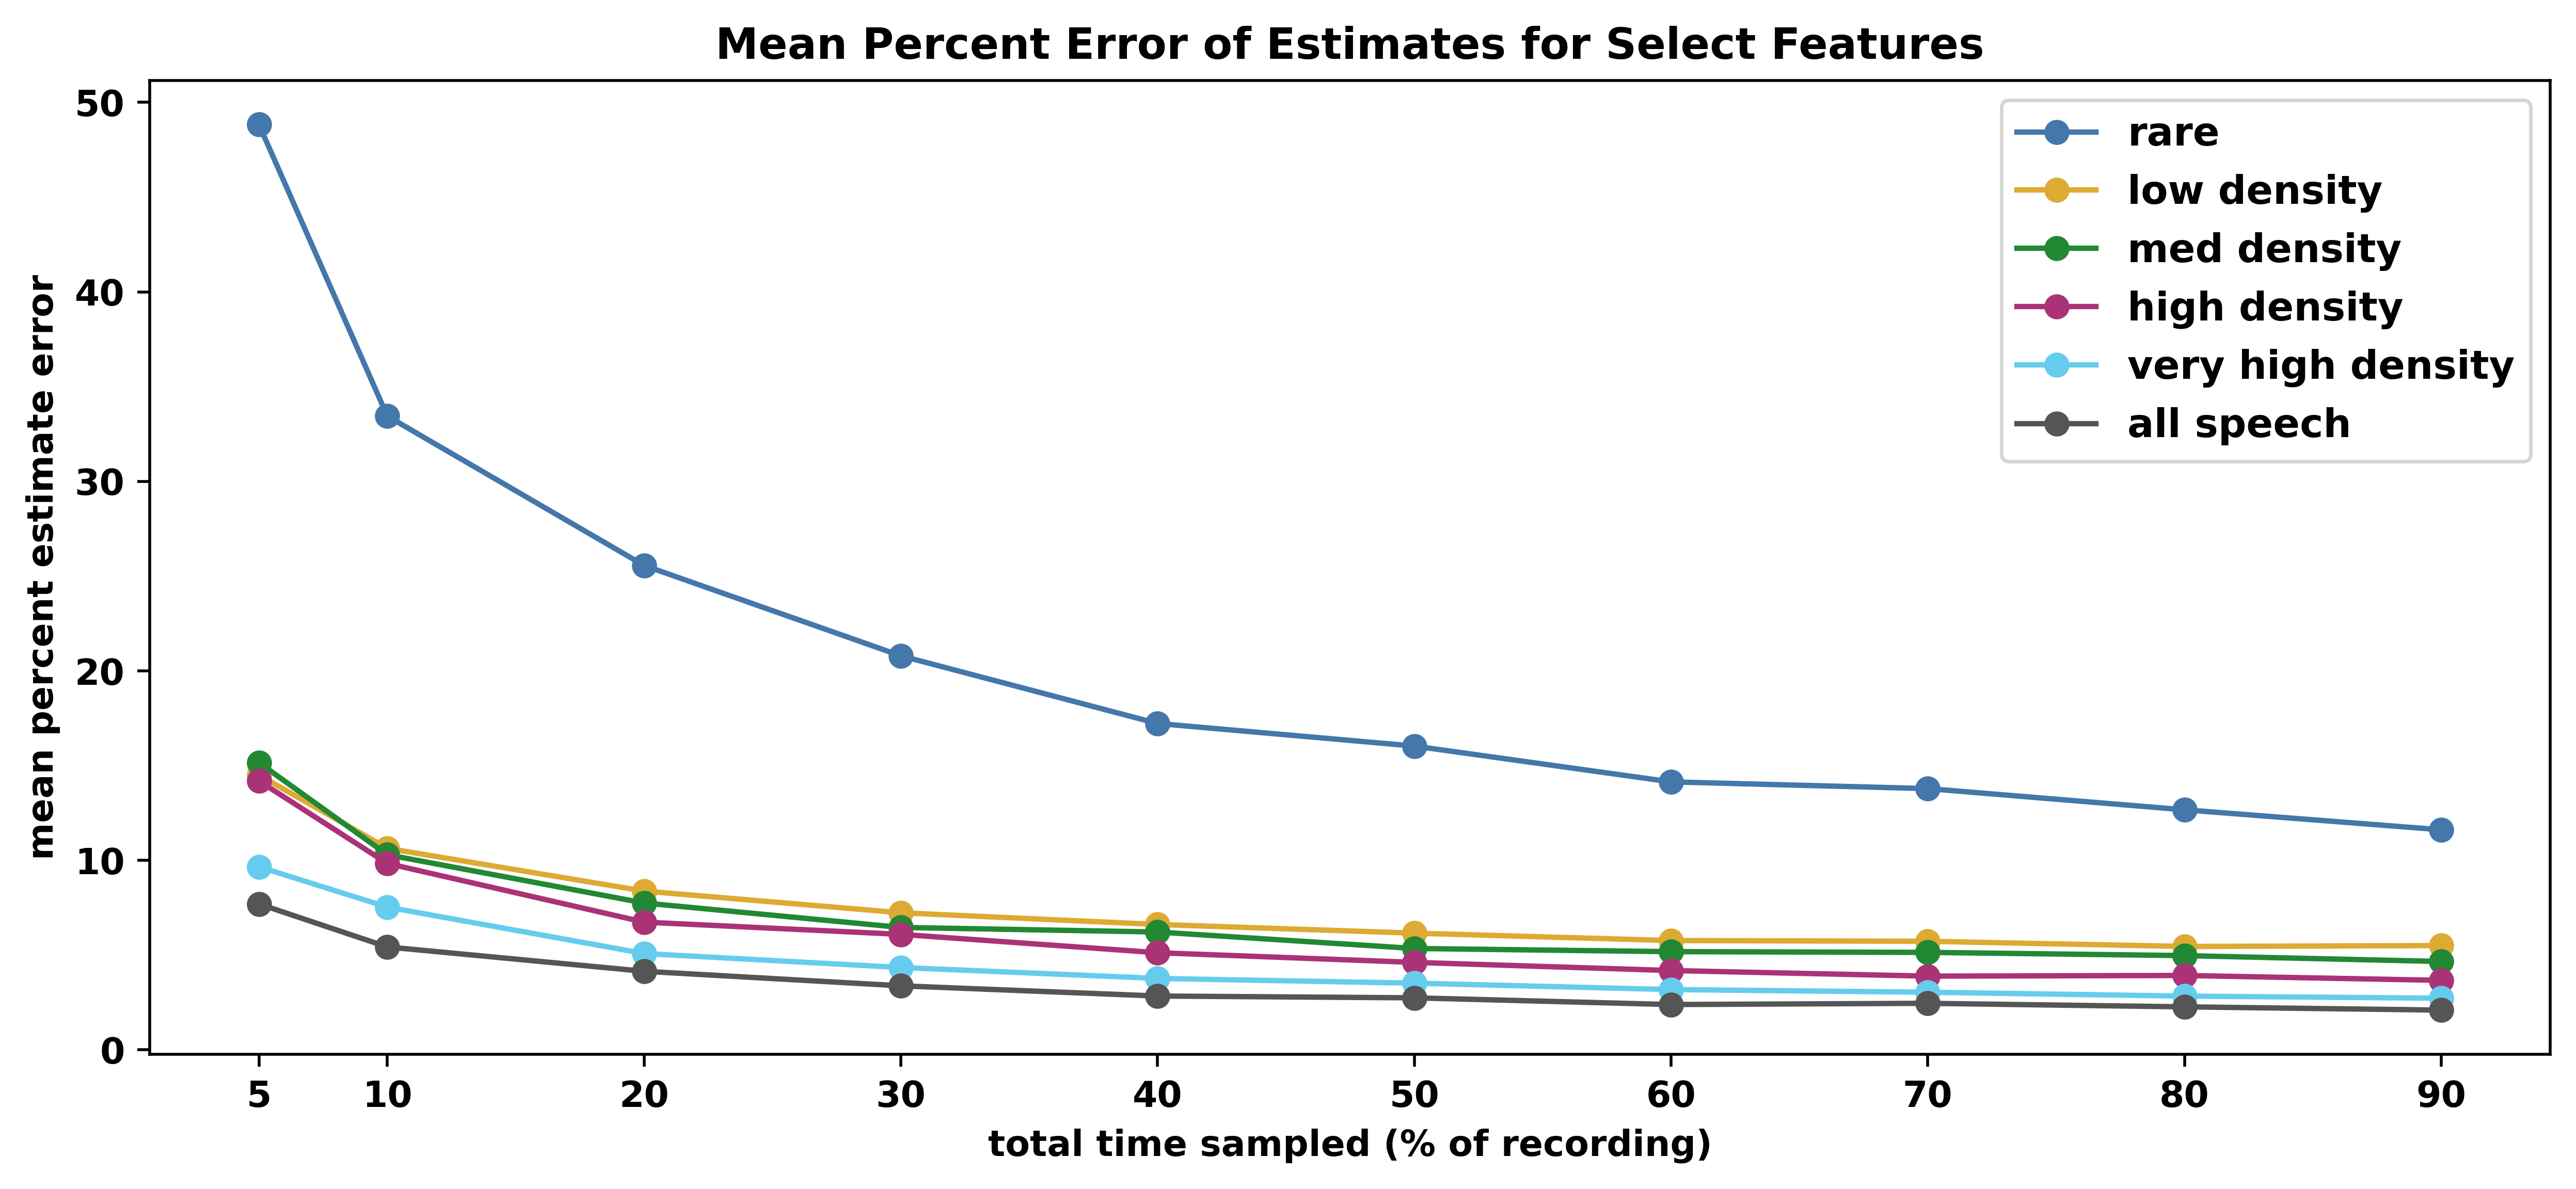

In [28]:
# BY FEATURE DENSITY 
colors_list = ['#4477AA', '#DDAA33', '#228833', '#AA3377', '#66CCEE', '#AA3377']
dfs= [ rare_density, low_density,med_density,high_density,very_high_density,perr_tts_asprop]
labels = ["rare","low density","med density","high density", "very high density","all speech"]
make_combined_errorplot(dfs = dfs, labels = labels, colors = colors_list[0:5] + ["#555555"], tts_type = "% of recording")

# Analysis: Non-overlapping Samples
##### - analysis to compare accuracy of estimates with overlapping samples (our implemented method) and non-overlapping samples 

### prep overlapping samples raw data for analysis 

In [7]:
def get_perr_errors(filenamepath, ground_truth):
    '''
    - return percent error for a single set of estimates (ex. file that contains estimates for one sampling interval size & one total sampled time)
    '''
    file = open(filenamepath, 'r')
    raw_estimates = file.readlines()[-1].split()
    estimate_accuracies = [(float(raw_estimate) / ground_truth) for raw_estimate in raw_estimates]
    perr_error = [round(abs( ( float(estimate) - ground_truth ) / ground_truth )*100,3) for estimate in raw_estimates]
    return perr_error

In [8]:
# read in overlapping samples data 
cols = {"0.05": 5, "0.1": 10, "0.2": 20, "0.3":30, "0.4":40, "0.5":50, "0.6":60, "0.7":70, "0.8":80, "0.9":90}
perr_overlapping = pd.read_csv("Results/CSVS/PercentError_propTTS.csv", 
                                 skiprows = 0, header = 1).rename(columns = cols )
perr_overlapping

,5,10,20,30,40,50,60,70,80,90,Transcript
0,5.729,7.506,3.977,5.374,3.770,2.790,0.967,3.214,1.860,5.626,A1
1,6.384,10.295,10.872,5.869,9.797,2.607,2.520,4.631,3.715,4.707,A1
2,4.432,6.083,1.695,8.891,0.273,8.650,1.635,6.914,4.240,4.245,A1
3,0.419,0.720,5.428,3.282,2.358,0.302,1.047,5.087,2.210,5.713,A1
4,3.566,2.084,2.378,1.360,1.908,6.251,4.204,3.253,0.218,3.311,A1
...,...,...,...,...,...,...,...,...,...,...,...
595,3.794,3.395,5.112,1.735,3.564,4.756,0.897,4.096,1.386,3.886,C
596,9.727,5.056,1.833,1.885,2.937,2.795,2.543,4.650,2.970,0.007,C
597,4.815,3.546,7.162,1.758,0.832,0.918,0.917,0.632,0.223,0.474,C
598,12.672,1.022,4.984,5.543,2.989,0.447,4.135,1.541,2.033,2.631,C


In [9]:
# read in nonoverlapping samples data
perr_nonoverlapping = pd.read_csv("Results/CSVS/daylongwc_nonoverlapping_samples_proptts.csv").rename(columns = cols )
perr_nonoverlapping

,5,10,20,30,Transcript,40,50,60
0,18.692,9.256,4.790,35.502,A1,NaN,NaN,NaN
1,15.134,7.947,4.989,37.025,A1,NaN,NaN,NaN
2,0.789,10.182,2.428,35.127,A1,NaN,NaN,NaN
3,1.728,0.008,7.131,34.563,A1,NaN,NaN,NaN
4,0.094,4.873,3.445,36.124,A1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
595,1.029,1.067,2.854,0.797,C,0.533,5.378,NaN
596,4.154,10.036,1.247,3.794,C,2.554,3.557,NaN
597,1.495,2.982,6.070,0.301,C,2.256,5.315,NaN
598,17.749,4.724,1.653,2.374,C,0.949,4.170,NaN


### Visualization

In [10]:
from matplotlib.transforms import ScaledTranslation

In [15]:
# dataframe cleaning
df_nonoverlapping = perr_nonoverlapping
df_nonoverlapping.loc[df_nonoverlapping['Transcript'] == "A1", PROP_TTS[2:7]] = np.nan
df_nonoverlapping.loc[df_nonoverlapping['Transcript'] == "A2", PROP_TTS[4:7]] = np.nan
df_nonoverlapping.loc[df_nonoverlapping['Transcript'] == "A3", PROP_TTS[5:7]] = np.nan
df_nonoverlapping.loc[df_nonoverlapping['Transcript'] == "B2", PROP_TTS[5:7]] = np.nan
df_nonoverlapping.loc[df_nonoverlapping['Transcript'] == "C", PROP_TTS[4:7]] = np.nan
df_nonoverlapping["Sampling"] = "without replacement"

df_overlapping = perr_overlapping
df_overlapping = df_overlapping.drop([70,80,90], axis=1)
df_overlapping.loc[df_overlapping['Transcript'] == "A1", PROP_TTS[2:7]] = np.nan
df_overlapping.loc[df_overlapping['Transcript'] == "A2", PROP_TTS[4:7]] = np.nan
df_overlapping.loc[df_overlapping['Transcript'] == "A3", PROP_TTS[5:7]] = np.nan
df_overlapping.loc[df_overlapping['Transcript'] == "B2", PROP_TTS[5:7]] = np.nan
df_overlapping.loc[df_overlapping['Transcript'] == "C", PROP_TTS[4:7]] = np.nan
df_overlapping["Sampling"] = "with replacement"

df_joined = pd.concat([df_overlapping, df_nonoverlapping])
df_joined


,5,10,20,30,40,50,60,Transcript,Sampling
0,5.729,7.506,NaN,NaN,NaN,NaN,NaN,A1,with replacement
1,6.384,10.295,NaN,NaN,NaN,NaN,NaN,A1,with replacement
2,4.432,6.083,NaN,NaN,NaN,NaN,NaN,A1,with replacement
3,0.419,0.720,NaN,NaN,NaN,NaN,NaN,A1,with replacement
4,3.566,2.084,NaN,NaN,NaN,NaN,NaN,A1,with replacement
...,...,...,...,...,...,...,...,...,...
595,1.029,1.067,2.854,0.797,NaN,NaN,NaN,C,without replacement
596,4.154,10.036,1.247,3.794,NaN,NaN,NaN,C,without replacement
597,1.495,2.982,6.070,0.301,NaN,NaN,NaN,C,without replacement
598,17.749,4.724,1.653,2.374,NaN,NaN,NaN,C,without replacement


In [50]:
grouped = df_joined.groupby("Sampling")

group =grouped.get_group("with replacement")
grp_means_overlapping, grp_stds_overlapping = grp_means_stds(group)

group =grouped.get_group("without replacement")
grp_means_nonoverlapping, grp_stds_nonoverlapping = grp_means_stds(group)

grp_means_overlapping - grp_means_nonoverlapping

5     0.363293
10    0.595615
20    0.962160
30    1.141218
40    1.126763
50    1.531830
60    1.259470
dtype: float64

<ipython-input-17-33344eae80b3>:17: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return group.mean(), group.std()
<ipython-input-19-d7230c714673>:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  xvals = df_joined.mean().index


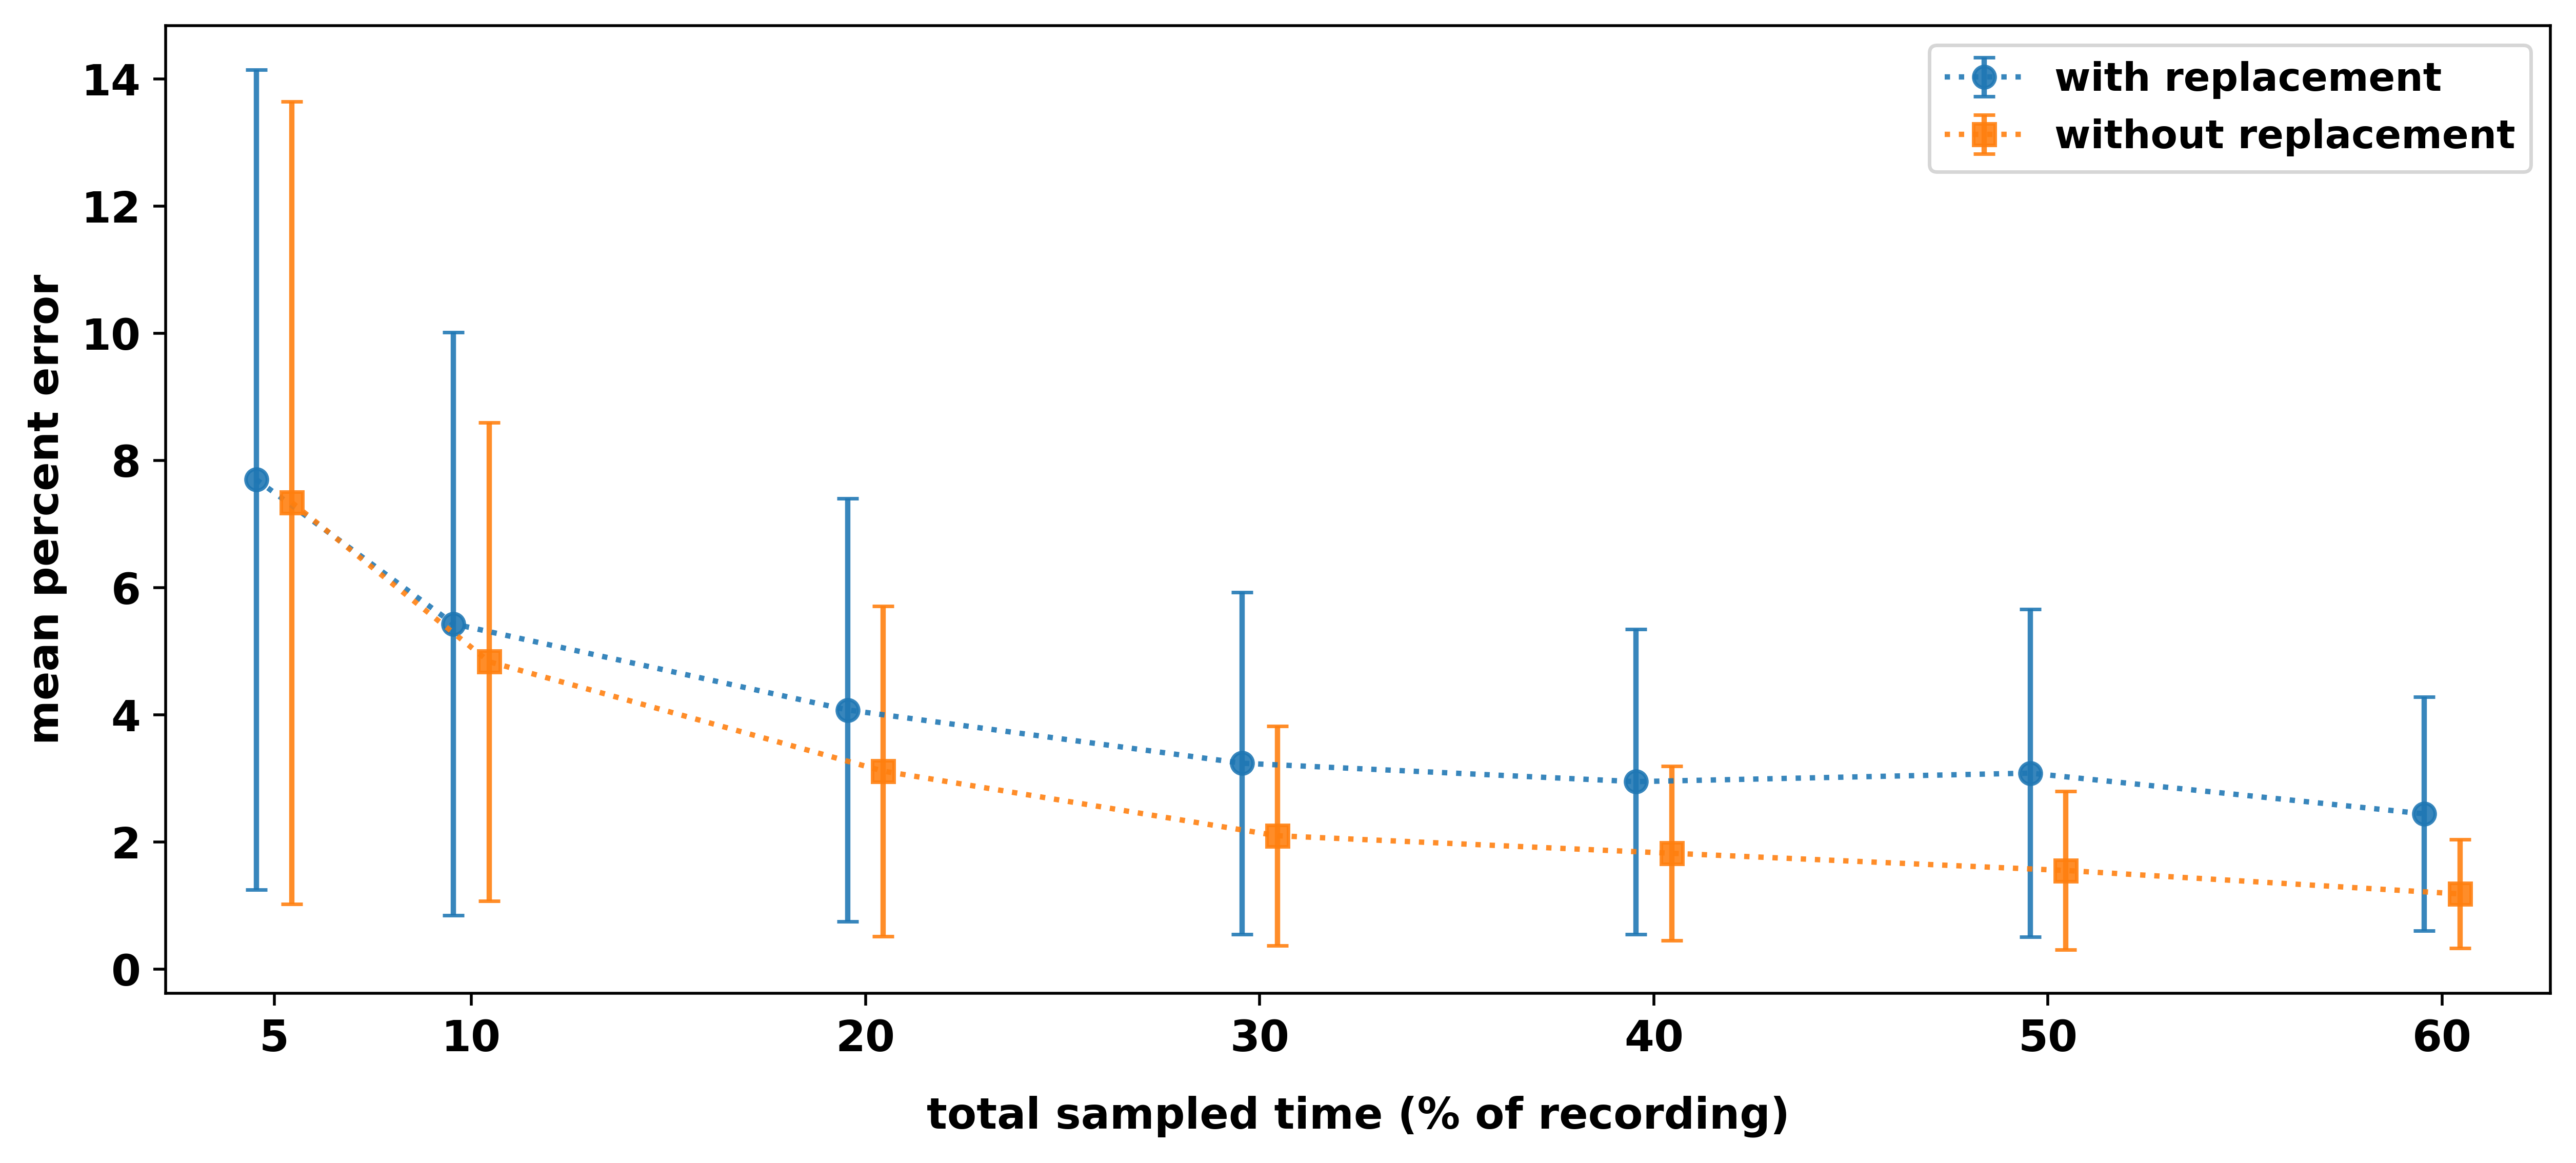

In [19]:
# plot 
fig,axes = plt.subplots(figsize = (12,5), dpi = 500)#, sharey = False)
trans1 = axes.transData + ScaledTranslation(-5/72, 0, fig.dpi_scale_trans)
trans2 = axes.transData + ScaledTranslation(+5/72, 0, fig.dpi_scale_trans)
grouped = df_joined.groupby("Sampling")

group =grouped.get_group("with replacement")
grp_means, grp_stds = grp_means_stds(group)
axes.errorbar(x=grp_means.index, y=grp_means, yerr = grp_stds,label="with replacement", marker = "o",transform=trans1,
              alpha=.89, fmt=':', capsize=3, capthick=1 )#, markerfacecolor = color_list[i], color = color_list[i])

group =grouped.get_group("without replacement")
grp_means, grp_stds = grp_means_stds(group)
axes.errorbar(x=grp_means.index, y=grp_means, yerr = grp_stds,label="without replacement", marker = "s", transform=trans2,
              alpha=.89, fmt=':', capsize=3, capthick=1 )#, markerfacecolor = color_list[i], color = color_list[i])

legend_properties = {'weight':'bold', 'size': 11}
axes.legend(prop=legend_properties) 
xvals = df_joined.mean().index
plt.xticks(list(list(xvals)))
plt.setp(axes.get_xticklabels(), fontsize=12, fontweight='bold')
plt.setp(axes.get_yticklabels(), fontsize=12, fontweight='bold')

axes.set_ylabel("mean percent error", fontsize = 12, fontweight = 'bold')
axes.set_xlabel("total sampled time (% of recording)", fontsize = 12, fontweight = 'bold', labelpad = 10)
#axes.set_title("Mean percent estimate error with and without sample replacement\nsampling interval size = 30 seconds", fontweight = "bold")
plt.show()